C:\Users\Touseef Iqbal\AppData\Local\Temp\ipykernel_27448\3148679560.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='IMD_Decile', y='DNA_Event', data=df, palette='viridis')


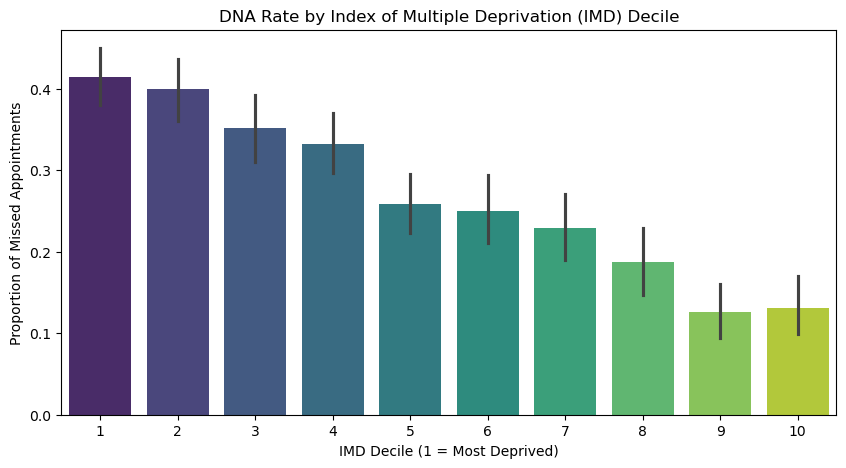

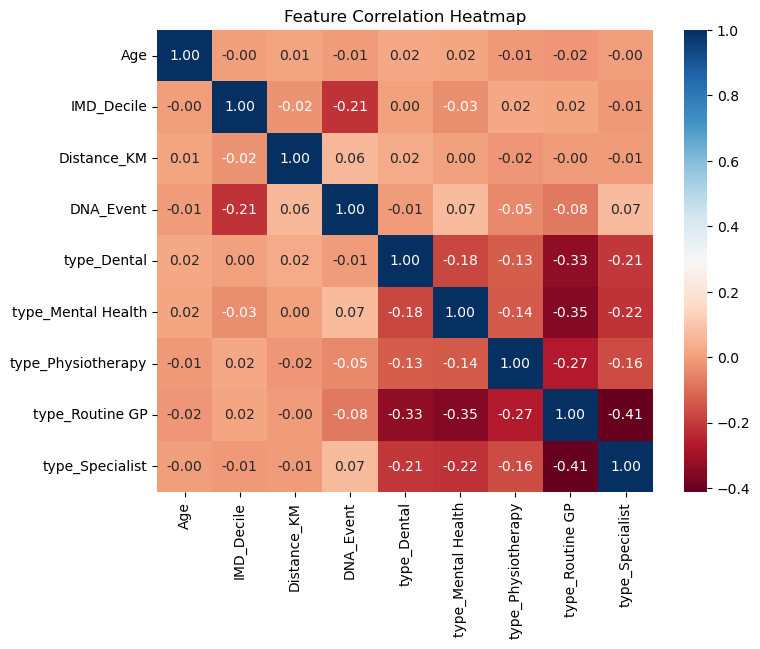

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- EDA ---
plt.figure(figsize=(10, 5))
df = pd.read_csv('nhs_patient_digital_twin_v1.csv')
# Plot 1: DNA Rate by IMD Decile
sns.barplot(x='IMD_Decile', y='DNA_Event', data=df, palette='viridis')
plt.title('DNA Rate by Index of Multiple Deprivation (IMD) Decile')
plt.ylabel('Proportion of Missed Appointments')
plt.xlabel('IMD Decile (1 = Most Deprived)')
plt.show()

# Plot 2: Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='RdBu', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [3]:
X = df.drop('DNA_Event', axis=1)
y = df['DNA_Event']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Professional XGBoost Setup
model = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Metrics
preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

print("--- Classification Report ---")
print(classification_report(y_test, preds))
print(f"ROC-AUC Score: {roc_auc_score(y_test, probs):.4f}")

# Model for the Dashboard
model.save_model('nhs_equity_model1.json')

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       723
           1       0.37      0.09      0.15       277

    accuracy                           0.71      1000
   macro avg       0.55      0.52      0.48      1000
weighted avg       0.63      0.71      0.63      1000

ROC-AUC Score: 0.6304


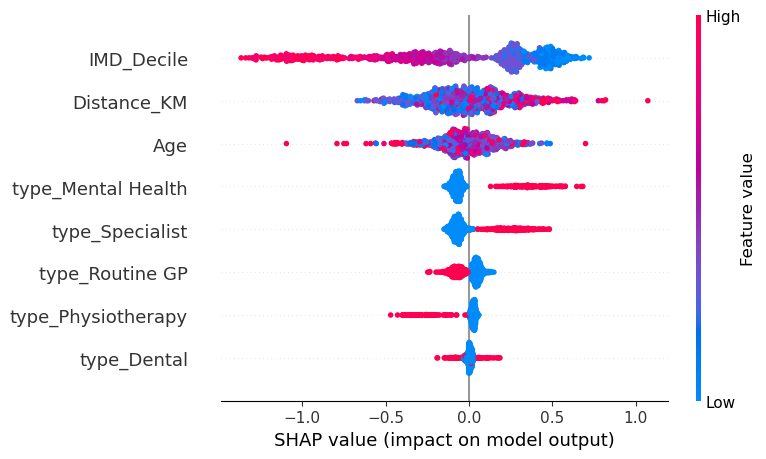

Analyzing Patient at index 355 with a DNA probability of 68.84%


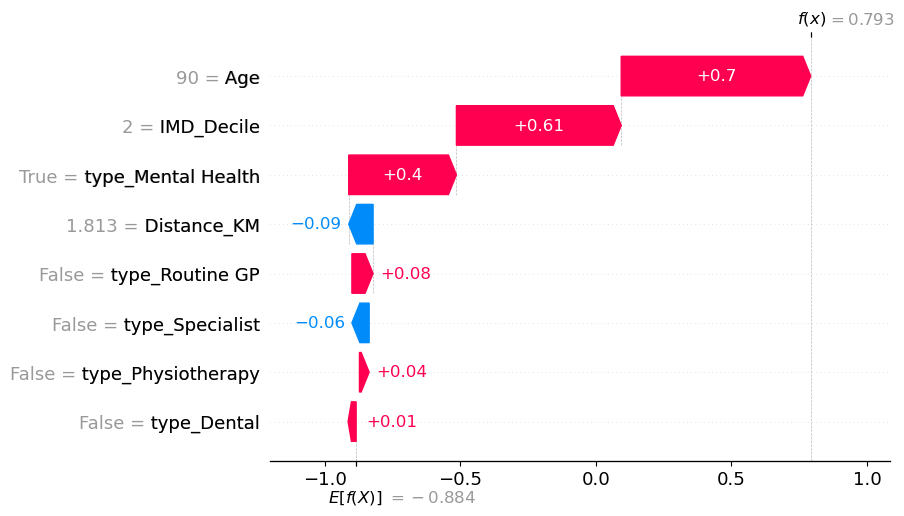

In [5]:
# --- =SHAP ANALYSIS ---
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# 1. Summary Plot
shap.summary_plot(shap_values, X_test)

# 2. Dynamic High-Risk Finder
# Find the index of the patient with the highest probability
high_risk_idx = np.argmax(probs) 
max_prob = probs[high_risk_idx]

print(f"Analyzing Patient at index {high_risk_idx} with a DNA probability of {max_prob:.2%}")

# 3. Waterfall Plot
# Ensure we use the shap_values for that specific index
shap.plots.waterfall(shap_values[high_risk_idx])